# Week 2 Assignment
## Team members:
- Marc Pérez Quintana  <br>
- Basem Elbarashy <br>
- Sergi Garcia Bordils <br>


## Notes:
- We list/explain at the start of each section the defined variables that will be used in the other sections 
- We assume that you have the following in the current dir:  
test/, train/ , test_images_filenames.dat , train_images_filenames.dat, test_labels.dat, train_labels.dat
- The code is tested with python 3 and opencv 3.4
- Most components are implemented in methods so we can easily play with them at the end of the notebook and tune the hyperparameters


In [86]:
import cv2
import numpy as np
import pickle as cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import accuracy_score

## 1) Read the train and test files and calculate class frequency
- train_images_filenames
- test_images_filenames
- train_labels
- test_labels

- Trainset Size =  1881
- Trainset classes count :  {'inside_city': 214, 'street': 212, 'Opencountry': 292, 'coast': 244, 'mountain': 260, 'highway': 184, 'tallbuilding': 248, 'forest': 227}
- Testset Size =  807
- Testset classes count:  {'inside_city': 94, 'street': 80, 'Opencountry': 118, 'coast': 116, 'mountain': 114, 'highway': 76, 'tallbuilding': 108, 'forest': 101}


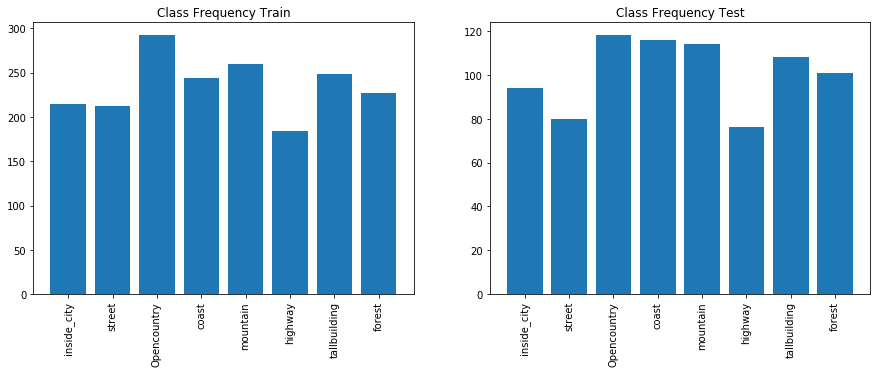

In [51]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

class_count_test = {}
for label in test_labels:
    if label in class_count_test:
        class_count_test[label] += 1
    else: 
        class_count_test[label] = 1
        
class_count_train = {}
for label in train_labels:
    if label in class_count_train:
        class_count_train[label] += 1
    else: 
        class_count_train[label] = 1

print('- Trainset Size = ', len(train_labels))
print("- Trainset classes count : ", class_count_train)
print('- Testset Size = ', len(test_labels))
print("- Testset classes count: ", class_count_test)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.bar(range(len(class_count_train)), list(class_count_train.values()))
plt.xticks(range(len(class_count_train)), list(class_count_train.keys()), rotation='vertical')
plt.title('Class Frequency Train')
plt.subplot(122)
plt.bar(range(len(class_count_test)), list(class_count_test.values()))
plt.xticks(range(len(class_count_test)), list(class_count_test.keys()), rotation='vertical')
plt.title('Class Frequency Test')
plt.show()

In [52]:
def histogramIntersection(M,N):
    kernel = np.zeros((M.shape[0], N.shape[0]))
    for d in range(M.shape[1]):
        column_1 = M[:, d].reshape(-1, 1)
        column_2 = N[:, d].reshape(-1, 1)
        kernel += np.minimum(column_1, column_2.T)
        #print(np.minimum(column_1, column_2.T).shape)
        #for i in range(column_1.shape[0]):
        #    for j in range(column_2.shape[0]):
        #        kernel[i,j] = np.minimum(column_1[i],column_2[j])
    return kernel

## Hyperparameters

In [57]:
num_features = 400 #number of features for the SIFT detector but for densesift it depends on step value
step = 10 #step between keypoints in dense SIFT
k = 1500 # codebook size / number of clusters for KMeans / number of words
num_neighbors = 5 #number of neighbors (k) for the k-nn classifier
knn_metric = 'manhattan'#distance for the k-nn classifier
denseSift = True #True if Dense SIFT is to be used, False for classical SIFT
pyramidDepth = 0 # 0-> No spatial pyramid, 1-> whole image + 4 subimages, 2-> lower levels + 16 subimages, ...
svm_C = 0.01 #margin parameter of the SVM classifier
svm_kernel = histogramIntersection # It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable 

normalization = True 
norm = 'power'  # l2 or power
steps = [10]  # [10, 10, 10, 10]  # steps for the different desc sizes
kpt_sizes = [10]  # [5, 10, 15, 20]  # desc sizes
alpha = 0.55


## Implementing Dense SIFT
- compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [58]:
def denseSIFT(images_filenames, labels):
    SIFTdetector = cv2.xfeatures2d.SIFT_create(num_features) # Create a SIFT object detector and descriptor
    descriptors = []
    label_per_descriptor = []
    kpts = []
    
    if denseSift:
        kpt = []
        # I moved this here to avoid computing the kpts for every image, since they all have the same size
        for step, size in zip(steps, kpt_sizes):  
            kpt.extend([cv2.KeyPoint(x, y, size) for y in range(0, 256, step) 
                                             for x in range(0, 256, step)])
    
    for filename, labels in zip(images_filenames, labels):
        filename = filename.replace("../../Databases/MIT_split", ".")
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)

        if denseSift:
            _, des = SIFTdetector.compute(gray, kpt)

        else:
            kpt, des = SIFTdetector.detectAndCompute(gray, None)
        
        if normalization:
            if norm == 'l2':
                des = normalize(des, norm, axis=0)
            if norm == 'power':
                des = np.sign(des) * (des**alpha)
                
        kpts.append(kpt)
        descriptors.append(des)
        label_per_descriptor.append(labels)

    return (kpts, descriptors)

### For each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [59]:
def get_visual_words(codebook, descriptors, kpts):
    num_images = len(descriptors)
    for level in range(pyramidDepth+1):
        if(level == 0):
            pyramid_visual_words = np.zeros((num_images, k), dtype=np.float32)
            for image in range(num_images):
                for word in codebook.predict(descriptors[image]):   
                    pyramid_visual_words[image,word]+=1
                pyramid_visual_words[image] = pyramid_visual_words[image] / pyramid_visual_words[image].sum()
            print("level 0 ->>>>>> "+str(pyramid_visual_words.sum()))
        else:
            for x in range(2**level):
                    for y in range(2**level): 
                        visual_words=np.zeros((num_images,k),dtype=np.float32)
                        for image in range(num_images):    
                            words = codebook.predict(descriptors[image])
                            for keypoint in range(len(kpts[image])):
                                x_pt, y_pt = kpts[image][keypoint].pt
                                if (x_pt>=x*256/(2**level) and x_pt<(x+1)*256/(2**level) and y_pt>=y*256/(2**level) and y_pt<(y+1)*256/(2**level)):
                                    visual_words[image, words[keypoint]]+=1
                            visual_words[image] = visual_words[image] / visual_words[image].sum()
                        pyramid_visual_words = np.append(pyramid_visual_words, visual_words, axis=1)
                        print("level "+str(level)+",x "+str(x)+",y "+str(y)+": "+str(visual_words.sum()))
                        print(x*256/(2**level), (x+1)*256/(2**level), y*256/(2**level), (y+1)*256/(2**level))
    return pyramid_visual_words

## Feature Extraction
### Raw data ==> Densesift descriptors ==> Visual words ==> Visual words pyramid ==> Feature standarization


In [61]:
# Densesift descriptors
Train_kpts, Train_descriptors = denseSIFT(train_images_filenames, train_labels)
Train_descriptors_vstacked = np.vstack(Train_descriptors)
Test_kpts, Test_descriptors = denseSIFT(test_images_filenames,   test_labels)

# Visual words
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(Train_descriptors_vstacked)

#  Visual words pyramid
visual_words_train = get_visual_words(codebook, Train_descriptors, Train_kpts)
visual_words_test  = get_visual_words(codebook, Test_descriptors, Test_kpts)

# Feature standarization
scaler = StandardScaler(with_mean=False)
scaler.fit(visual_words_train)

visual_words_train = scaler.transform(visual_words_train)
visual_words_test  = scaler.transform(visual_words_test)

# Compare between data size and feature size
print('traindata size: ',visual_words_train.shape[0])
print('Feature size: ',visual_words_train.shape[1])

level 0 ->>>>>> 1881.0005
level 0 ->>>>>> 807.00006
traindata size:  1881
Feature size:  1500


## Trying different classifiers 

In [43]:
## Knn classifier
knn = KNeighborsClassifier(n_neighbors=num_neighbors,n_jobs=-1,metric=knn_metric)
knn.fit(visual_words_train, train_labels)
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)


43.74225526641883


In [91]:
## SVM classifier
clf = svm.SVC(kernel=svm_kernel, C = svm_C)
clf.fit(visual_words_train, train_labels)
#accuracy = 100*clf.score(visual_words_test, test_labels)

predicted_test = clf.predict(visual_words_test)
accuracy = accuracy_score(predicted_test, test_labels, normalize=True)
print(accuracy)
               
## SVM classifier with SGD!
#clf = SGDClassifier(alpha=.0001, n_iter=60, penalty='l2', shuffle=True, random_state=0,verbose=0)
#clf.fit(visual_words, train_labels)
#accuracy = 100*clf.score(visual_words_test, test_labels)
#print(accuracy)

0.8711276332094176


## Plot confusion matrix of the SVM classifier

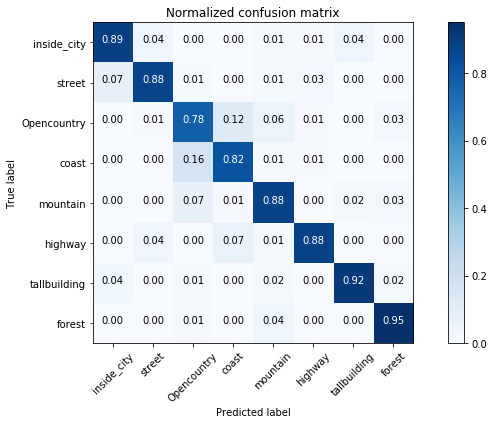

In [92]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
class_names = list(class_count_train.keys())
cnf_matrix = confusion_matrix(test_labels, predicted_test, labels=class_names)
plt.figure(figsize=(10,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()




## Create 5 Stratified Folds for Cross-validation

In [45]:
def evaluate_model():
    validation_split_num = 1
    accuracys = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    skf_split = skf.split(train_images_filenames, train_labels)
    skf_split = skf.split(train_images_filenames, train_labels)
    for train_index, validation_index in skf_split:
        print(validation_split_num)
        cv_train_images_filenames = []
        cv_train_labels = []
        validation_images_filenames = []
        validation_labels = []
        for index in train_index:
            cv_train_images_filenames.append(train_images_filenames[index])
            cv_train_labels.append(train_labels[index])                
        for index in validation_index:
            validation_images_filenames.append(train_images_filenames[index])
            validation_labels.append(train_labels[index]) 

        cv_Train_kpts, cv_Train_descriptors  = denseSIFT(cv_train_images_filenames, cv_train_labels)
        D = np.vstack(cv_Train_descriptors)
        Validation_kpts, Validation_descriptors = denseSIFT(validation_images_filenames, validation_labels)
        
        codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
        codebook.fit(D)
        
        visual_words_train = get_visual_words(codebook, cv_Train_descriptors, cv_Train_kpts)
        visual_words_validation = get_visual_words(codebook, Validation_descriptors, Validation_kpts)
        
        knn = KNeighborsClassifier(n_neighbors=num_neighbors,n_jobs=-1,metric=knn_metric)
        knn.fit(visual_words_train, cv_train_labels)
        
        scaler = StandardScaler()
        scaler.fit(visual_words_train)
        visual_words_train = scaler.transform(visual_words_train)
        visual_words_validation = scaler.transform(visual_words_validation)

        accuracyKNN = 100*knn.score(visual_words_validation, validation_labels)
        
        ## SVM classifier
        clf = svm.SVC(kernel=svm_kernel, C = svm_C)
        clf.fit(visual_words_train, cv_train_labels)
        accuracySVM = 100*clf.score(visual_words_validation, validation_labels)
        accuracys.append(accuracySVM)

        with open('parameters_execution.log', 'a') as f:
            f.write('denseSift: '+str(denseSift)+', '+
                    'num_features: '+str(num_features)+', '+
                    'k: '+str(k)+', '+
                    'num_neighbors: '+str(num_neighbors)+', '+
                    'knn_metric: '+str(knn_metric)+', '+
                    'step: '+str(step)+', '+
                    'pyramidDepth: '+str(pyramidDepth)+', '+
                    'validation_split_num: '+str(validation_split_num)+', '+
                    'normalization: '+str(normalization)+', '+
                    'norm: '+str(norm)+', '+
                    'alpha: '+str(alpha)+', '+
                    'kpt_sizes: '+str(kpt_sizes)+', '+
                    'accuracySVM: '+str(accuracySVM)+', '+
                    'accuracyKNN: '+str(accuracyKNN)+'\n')
        validation_split_num += 1

    return accuracys

In [47]:
acc = evaluate_model()
print(acc)

1
level 0 ->>>>>> 1501.9996
level 1,x 0,y 0: 1502.0
0.0 128.0 0.0 128.0
level 1,x 0,y 1: 1502.0001
0.0 128.0 128.0 256.0
level 1,x 1,y 0: 1502.0007
128.0 256.0 0.0 128.0
level 1,x 1,y 1: 1502.0001
128.0 256.0 128.0 256.0
level 0 ->>>>>> 379.00003
level 1,x 0,y 0: 379.00003
0.0 128.0 0.0 128.0
level 1,x 0,y 1: 379.00003
0.0 128.0 128.0 256.0
level 1,x 1,y 0: 378.99997
128.0 256.0 0.0 128.0
level 1,x 1,y 1: 379.0
128.0 256.0 128.0 256.0
2
level 0 ->>>>>> 1501.9996
level 1,x 0,y 0: 1501.9999
0.0 128.0 0.0 128.0
level 1,x 0,y 1: 1502.0
0.0 128.0 128.0 256.0
level 1,x 1,y 0: 1502.0001
128.0 256.0 0.0 128.0
level 1,x 1,y 1: 1502.0005
128.0 256.0 128.0 256.0
level 0 ->>>>>> 378.99982
level 1,x 0,y 0: 379.0
0.0 128.0 0.0 128.0
level 1,x 0,y 1: 378.99997
0.0 128.0 128.0 256.0
level 1,x 1,y 0: 379.00003
128.0 256.0 0.0 128.0
level 1,x 1,y 1: 378.99997
128.0 256.0 128.0 256.0
3
level 0 ->>>>>> 1505.0005
level 1,x 0,y 0: 1505.0002
0.0 128.0 0.0 128.0
level 1,x 0,y 1: 1505.0004
0.0 128.0 128.0 256.

## Conclusion 
- We found that the dataset is balanced and therefore there is no need to use class_weight for loss calculation while training or any other solution